<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/DFOF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import tifffile
import numpy as np
from google import colab

# # Open Bin Save
def get_drobox_file(new_filename, link):
    !wget -O $new_filename $link
    return new_filename


def bin_stack(im,bin_factor):
    height = im.shape[1] // bin_factor
    width = im.shape[2] // bin_factor
    im = im[:, :height * bin_factor, : width * bin_factor]
    im = im.reshape(im.shape[0], height, bin_factor, width, bin_factor)
    im = im.sum((2, 4), dtype='uint32')
    return im


def open_bin_save(db_link,new_name,bin_factor):
    print('importing')
    _ = get_drobox_file(new_name, db_link)
    print('reading')
    im = tifffile.imread('/content/'+new_name, maxworkers=6)
    print('binning')
    im = bin_stack(im, bin_factor)
    print('saving')
    tifffile.imwrite('/content/my_tiff_bin.tiff', im) #, imagej=True

    !zip -r '/content/my_tiff_bin.zip' '/content/my_tiff_bin.tiff'

    print('downloading')
    colab.files.download('/content/my_tiff_bin.zip')
    return im

new_name = 'my_tiff.tiff'
db_link = 'https://www.dropbox.com/s/25s9avjszghte1k/s3_cnt%5B1-5000_EX0%5D.TIF?dl=0'
bin_factor=6
im = open_bin_save(db_link,new_name,bin_factor)


importing
--2023-05-17 04:13:53--  https://www.dropbox.com/s/25s9avjszghte1k/s3_cnt%5B1-5000_EX0%5D.TIF?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/25s9avjszghte1k/s3_cnt%5B1-5000_EX0%5D.TIF [following]
--2023-05-17 04:13:53--  https://www.dropbox.com/s/raw/25s9avjszghte1k/s3_cnt%5B1-5000_EX0%5D.TIF
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc12065196a0af0fa9d725cb29a.dl.dropboxusercontent.com/cd/0/inline/B8Ngu0xSNpMFDMMv1U2u2Qr6BPPgcn56xfGlSaAPYMRyD9Oc7nrP0kJ5gPEVvRFv4ryMkbNK7uMEV_8qa0jaVl3KTb1PjC0gSCMXRqHBzq8-yJfVQHFGt_RDTTkLzrhfx94ttbcVJi9cCD02XTpgjOxs4AG7FYOeQfbnc5w23lca_A/file# [following]
--2023-05-17 04:13:54--  https://ucc12065196a0af0fa9d725cb29a.dl.dropboxusercontent.com/cd/0/inline/B8Ngu0xSNpMFDMMv1U2u2Qr

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [49]:
im_shape = im.shape
im_r = np.reshape(im, [im_shape[0], im_shape[1]*im_shape[2]])
print(im_r.shape)

(5000, 10000)


In [62]:
from matplotlib import pyplot as plt
from sklearn.decomposition import FastICA, TruncatedSVD
import sklearn

In [51]:
im_r_std = np.expand_dims(np.std(im_r,axis=0),1)
im_r_avg = np.expand_dims(np.average(im_r,axis=0),1)
im_r_n = (im_r-im_r_avg.T)/im_r_std.T


In [52]:
f0 = 1200
im_r_d = im_r / im_r[f0,:]

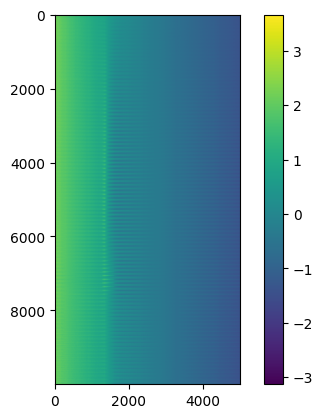

In [53]:
plt.imshow(im_r_n.T)
plt.colorbar()
plt.show()

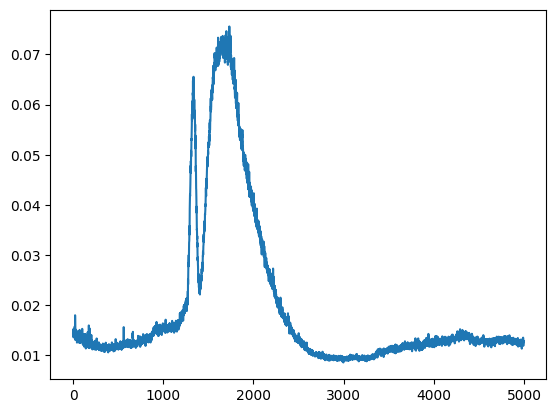

In [97]:
plt.plot(np.var(im_r_n,axis=1))

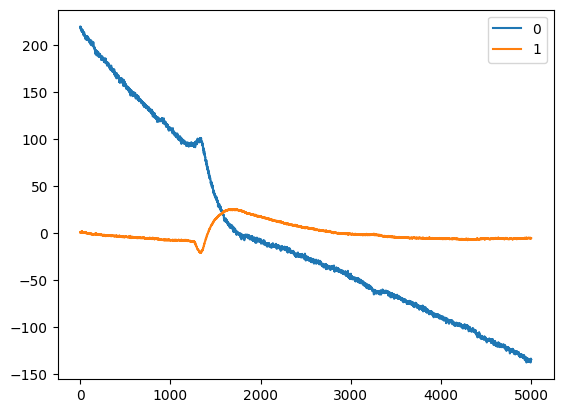

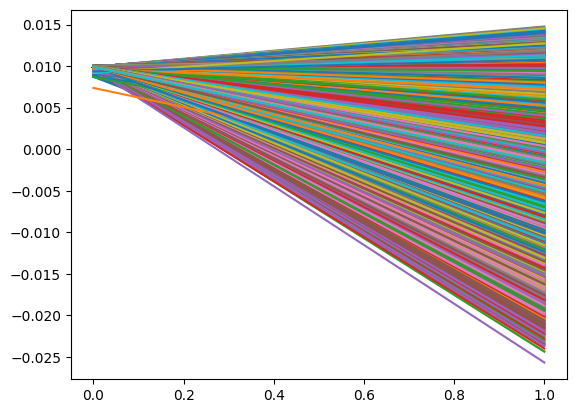

In [85]:
from sklearn.utils.extmath import randomized_svd

u, s, vt = randomized_svd(im_r_n,n_components=2,n_iter=5,random_state=None)
plt.plot(u * s)
plt.legend(np.arange(4))
plt.show()
plt.plot(vt)
plt.show()

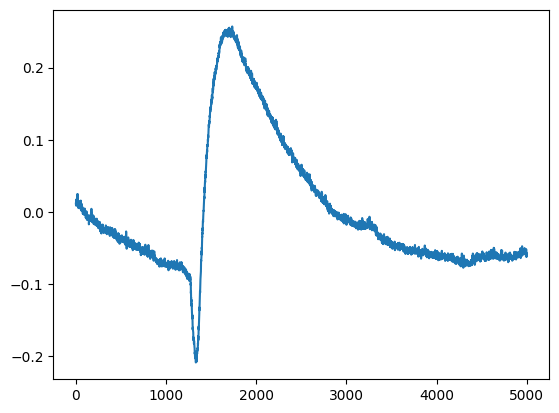

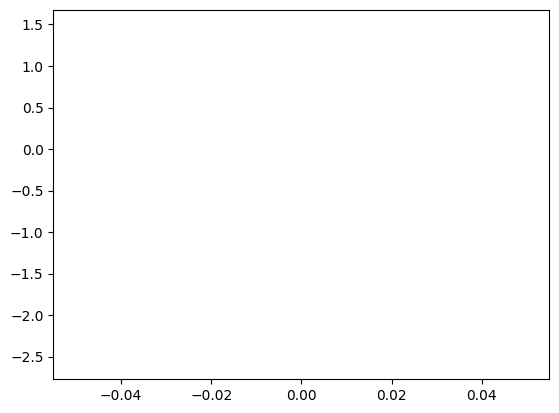

In [87]:

ica = FastICA(n_components=1,random_state=0,whiten='unit-variance')
im_trans =  ica.fit_transform(im_r_n.T)
A_ = ica.mixing_  # Get estimated mixing matrix
plt.plot(A_)
plt.show()
plt.plot(im_trans.T)
plt.show()